In [1]:
import datasets.utils as datautils
import utils.dgreg_utils as utils
from tensorboardX import SummaryWriter
import torch
from torch import optim
import torch.nn.functional as F
import argparse
import csv
import os
import numpy as np
from copy import deepcopy
import random
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

from models.networks import Reg_Domain

In [2]:
net = Reg_Domain(do_emb_size=256, eg_emb_size=16, pretrain=True)
print(net)

/mnt/disk1/mbbank/miniconda3/envs/gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will be removed in 0.15. Please access them via the appropriate Weights Enum instead.
  warnings.warn(
/mnt/disk1/mbbank/miniconda3/envs/gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/mnt/disk1/mbbank/miniconda3/envs/gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Reg_Domain(
  (extractor): ResnetFeatureExtractor(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu):

In [3]:
model_name = "./ckpt/_step_29.pth"

pretained_model = torch.load(model_name)
model_dict = net.state_dict()
state_dict = {k: v for k, v in pretained_model.items() if k in model_dict.keys()}
model_dict.update(state_dict)
net.load_state_dict(model_dict)

<All keys matched successfully>

In [1]:
# Build DataLoader and Iterator
dataset = 'live'

folder_path = {
    'live': './data/databaserelease2',
    'csiq': './data/csiq',
    'tid2013': './data/TID2013',
    'livec': './data/ChallengeDB',
    'koniq': './data/KonIQ',
    'bid': './data/BID',
    'kadid-F': './data/kadid10k'
}

dataset_path = folder_path[dataset]

img_num = {
    'live': list(range(0, 29)),
    'csiq': list(range(0, 30)),
    'tid2013': list(range(0, 25)),
    'livec': list(range(0, 1162)),
    'koniq': list(range(0, 10073)),
    'bid': list(range(0, 586)),
    'kadid-F':list(range(0,81))
}
sel_num = img_num[dataset]

In [2]:
train_index = sel_num[0:int(round(0.8 * len(sel_num)))]
test_index = sel_num[int(round(0.8 * len(sel_num))):len(sel_num)]

In [6]:
train_loader = datautils.make_dataloader(
        dataset_name=dataset,
        dataset_path=dataset_path,
        csv_path=None,
        task_list=None,
        level_list=None,
        bs=1,
        shuffle=True,
        num_workers=3,
        drop_last=True,
        mode='all',
        trainsz=train_index, patch_num=25,sel='all')

In [7]:
print(next(net.parameters()).device)

cpu


In [8]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([1, 3, 224, 224])
Labels batch shape: torch.Size([1])


In [9]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

Label: tensor([75.7355])


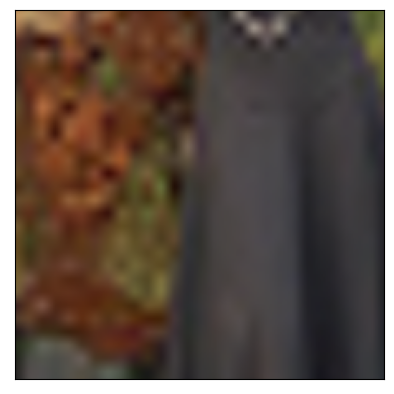

In [15]:
img = np.array(invTrans(train_features[0].squeeze()))
img = img.transpose(1, 2, 0)
plt.imshow(img)
print(f"Label: {train_labels}")
# plt.title("qaq: {}".format(y))
plt.xticks([])
plt.yticks([])
plt.show()


In [11]:
train_features[0].size()

torch.Size([3, 224, 224])

In [12]:
net.eval()
net.to(torch.device('cuda'))
score , do_code, level_pred, type_pred = net(train_features.to(torch.device('cuda')))

In [13]:
score

tensor([[67.7129]], device='cuda:0', grad_fn=<AddBackward0>)